print("CPU Status:")
!cat /proc/cpuinfo | grep model\ name # Check CPU info
print("\nDisk Status:")
!df -lh 
print("\nRAM Status:")
!free -h 
print("\nGPU Status:")
import tensorflow as tf
tf.test.gpu_device_name() #Check GPU activate or not
print("\nCurrent working directory :")
!pwd

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
from datetime import datetime

C:\Program Files\Anaconda2\envs\py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def PlotConfusionMatrix(cm, show=True, save=True,tick_name=''):
    label_size = cm.shape[0]
    
    fig, ax = plt.subplots()   
    cm_img = ax.matshow(cm,cmap='copper')#copper is better
    fig.colorbar(cm_img)
    ax.set_title('ConfusionMatrix',fontdict={'fontsize':15})
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted') 
    tick_loc = np.arange(label_size)
    if tick_name == '':
       plt.xticks(tick_loc, range(label_size))
       plt.yticks(tick_loc, range(label_size)) 
    else:
       plt.xticks(tick_loc, tick_name)
       plt.yticks(tick_loc, tick_name)        
    ax.tick_params(axis='x', labelcolor='r') 
    ax.tick_params(axis='y', labelcolor='r')
    # Turn fig boundary line off and create white grid.    
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks(tick_loc[0:-1]+0.5, minor = True)
    ax.set_yticks(tick_loc[0:-1]+0.5, minor = True)        
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)   
    # Loop over data dimensions and create text annotations.
    for i in range(label_size):
        for j in range(label_size):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center", color="w")
    plt.tight_layout()
    if save:
       plt.savefig(os.path.join(save_main_path,'ConfusionMatrix.png'),bbox_inches='tight',dpi=300)          
    if show:
       plt.show()
    else:
       plt.close()
       return fig

In [3]:
def RunTestSet(model,data,save=True):     
    image_batch, label_batch = data.feeder(data.test_iterator)                
    test_accuracy, confusion_mtx = model.sess.run([model.accuracy,model.confusion],
                                             feed_dict={model.x_img: image_batch*(1./255), 
                                                        model.y_label: label_batch,
                                                        model.keep_prob: 1.0})              
    print ('Test-set Acc: %4.2f%%'%(test_accuracy*100))  
    print ('Test-set ConfusionMatrix: \n',confusion_mtx)
    if save:
       np.savetxt(os.path.join(save_main_path,'TestAcc%4.2f_ConfusionMatrix.csv'%(test_accuracy*100)),confusion_mtx, delimiter=',', fmt=str("%d"))  
    PlotConfusionMatrix(confusion_mtx,show=True,save=save)

In [4]:
def PlotAccLoss(result,save=False):
    steps_per_epoch = round(data_size['train']/batch_size['train']) 
    epochs = [s/steps_per_epoch for s in result['step']] 

    fig1, ax1 = plt.subplots(num='Acc')
    ax1.set_title('Acc',fontdict={'fontsize':22,'position':(0.5, 0.08)})
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('step')    
    ax1.plot(result['step'],result['train_acc'],'r-', label='train_acc')
    ax1.plot(result['step'],result['vali_acc'],'b-', label='vali_acc')
    ax1.tick_params(axis='x', labelcolor='k',direction='in')   
    ax2 = ax1.twiny() # share same y axis
    ax2.set_xlabel('epoch',color='g')
    ax2.plot(epochs,result['train_acc'],'r-', label='train_acc')
    ax2.plot(epochs,result['vali_acc'],'b-', label='vali_acc')    
    ax2.tick_params(axis='x', labelcolor='g',direction='in')    
    plt.ylim(0,1.1)
    plt.legend(loc='best')
    fig1.tight_layout()
    if save:
       plt.savefig(os.path.join(save_main_path,'Acc.png'),bbox_inches='tight',dpi=150)      
    plt.show()

    fig3, ax3 = plt.subplots(num='Loss')
    ax3.set_title('Loss',fontdict={'fontsize':22,'position':(0.5, 0.08)})
    ax3.set_ylabel('loss')
    ax3.set_xlabel('step')    
    ax3.plot(result['step'],result['train_loss'],'r-', label='train_loss')
    ax3.plot(result['step'],result['vali_loss'],'b-', label='vali_loss')
    ax3.tick_params(axis='x', labelcolor='k',direction='in')   
    ax4 = ax3.twiny() 
    ax4.set_xlabel('epoch',color='g')
    ax4.plot(epochs,result['train_loss'],'r-', label='train_loss')
    ax4.plot(epochs,result['vali_loss'],'b-', label='vali_loss')    
    ax4.tick_params(axis='x', labelcolor='g',direction='in')    
    plt.legend(loc='best')
    fig1.tight_layout()
    if save:
       plt.savefig(os.path.join(save_main_path,'Loss.png'),bbox_inches='tight',dpi=150)      
    plt.show()

In [5]:
def SaveAccLossValue(result):
    my_data_result = pd.DataFrame({
                      "step": result['step'],
                      "train_acc": result['train_acc'],  
                      "vali_acc": result['vali_acc'],
                      "train_loss": result['train_loss'],  
                      "vali_loss": result['vali_loss'],                       
                      })         
    my_data_result.to_csv(os.path.join(save_main_path,'AccLoss.csv'),sep=',') 

In [6]:
def FigToSummary(fig, tag): 
    """
    Adapted from https://github.com/wookayin/tensorflow-plot/blob/master/tfplot/figure.py
    Convert a matplotlib figure ``fig`` into a TensorFlow Summary object
    that can be directly fed into ``Summary.FileWriter``.
      >>> fig, ax = ...
      >>> summary = Fig2summary(fig, tag='MyFigure/image')
      >>> summary_writer.add_summary(summary, global_step)
    """
    from io import BytesIO
    from tensorflow import Summary
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    # get PNG data from the figure
    png_buffer = BytesIO()
    fig.canvas.print_png(png_buffer)
    png_encoded = png_buffer.getvalue()
    png_buffer.close()    
    summary_image = Summary.Image(height=h, width=w, colorspace=4,  # RGB-A
                                  encoded_image_string=png_encoded)
    summary = Summary(value=[Summary.Value(tag=tag, image=summary_image)])
    return summary

In [7]:
def RestoreModelVariable(sess, model_path):
    """Based on CnnModelClass.build_saver()
    """
    print('-------------------------------------------')
    print('Restoring Model Variables...') 
    StartTime = datetime.now()
    # Use import_meta_graph to load meta data
    saver = tf.train.import_meta_graph(model_path+'.meta')
    saver.restore(sess, model_path)    
    x_img = tf.get_collection("InputImg")[0] #placeholder
    y_label = tf.get_collection("Inputlabel")[0] #placeholder
    keep_prob = tf.get_collection("Dropout")[0] #placeholder
    training = tf.get_collection("isTraining")[0] #placeholder 
    output_propb = tf.get_collection("OutputPropb")[0]
    output_label = tf.get_collection("OutputLabel")[0]
    #train_step = tf.get_collection("TrainSteps")[0]    
    #graph = tf.get_default_graph() # find tensor name in graph   
    #for op in graph.get_operations(): 
    #   if 'Placeholder' in op.name: print(op.name)      
    #keep_prob = graph.get_tensor_by_name('Fully-Connected-Layer-2/Placeholder:0')
    EndTime = datetime.now() 
    print ('Time usage : %s '%str(EndTime-StartTime))
    print('-------------------------------------------')
    return x_img, y_label, keep_prob, training, output_propb, output_label

In [8]:
def PredMyRealImgs(modelpath,imgfolder=''):       
    label_def = {'0':['led'],
                 '1':['cfl','ccfl','fluorescent','fluorescence','mercury','hg'],
                 '2':['sun','sky','solar','star','stellar','incandescent','tungsten','halogen','quartz'],
                 '3':['neon','ne'],
                 '4':['helium','he'],   
                 '5':['hydrogen','h'],
                 '6':['nitrogen']}
    img_list = ['neon_21411.png', 'cfl_P_20180714_conti.jpg',                       
                'cfl_DSC5202.JPG','neon_IMG_9999_full.JPG',                       
                'neon_DSC_2624.JPG','cfl_2936.png',                      
                'he_20s_corp.jpg','neon_IMG_20170118.jpg',                      
                'led_8973.jpg','led_3144553_n.jpg',                       
                'sky_80865_n.jpg','cfl_609251_n.jpg',                      
                'led_2448841_n.jpg','neon_DSC_2991.JPG',                       
                'sun_95084215_n.jpg','sun_97600_n.jpg',
                'he_8550.jpg','h_100897.png',
                'sun_sun.jpg','cfl_IMG_20170106.jpg']                                                                  
    #true_labels = [3,1,1,3,3,1,4,3,0,0,2,1,0,3,2,2,4,5,2,1]
    img_class = [n.split('_')[0] for n in img_list]
    true_labels = []
    for ic in img_class:
        for key, values in label_def.items():            
            if ic in values: true_labels.append(int(key)) 
        
    if imgfolder=='':                             
       mainpath = os.path.join(os.getcwd(),'RawData','MyRealImgs')  
    else:
        mainpath = imgfolder            
    # Restore model variable 
    tf.reset_default_graph()
    sess = tf.Session()
    x_img, y_label, keep_prob, training, output_propb, output_label = RestoreModelVariable(sess,modelpath)
          
    import ImgPreprocessSingle as ips
    pred_labels = [] 
    for idx, imgname in enumerate(img_list):
        path = os.path.join(mainpath,imgname)   
        img = ips.img_preprocess(imgpath=path, savepath='', new_shape=(480,15), auto_flip=False, plot=False)    
        if img is not '': 
           image_shape = img.shape 
           img = img.reshape((-1, image_shape[0], image_shape[1], 3))           
           label, propb = sess.run([output_label,output_propb], 
                                   feed_dict = {x_img: img*(1./255), 
                                                keep_prob: 1.0})
           pred_labels.append(label[0])
           print(imgname+' :')
           print('TrueLabel   =', true_labels[idx])               
           print('PredLabel   =', label[0])
           print('Probability =',['%.2f'%(p) for p in propb[0]],'\n')
        else:
           print(imgname+' :','False of img_preprocess')               
    print ('True label : ', true_labels)
    print ('Pred label : ', pred_labels)    
    correct = np.equal(true_labels, pred_labels).astype(int)
    acc = np.mean(correct)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true=true_labels,y_pred=pred_labels)
    tick_name = [value[0] for value in label_def.values() ]
    PlotConfusionMatrix(cm, show=True, save=False,tick_name=tick_name)
    sess.close()
    print ('MyRealImgs Acc: %4.2f%%'%(acc*100)) 
    print('-------------------------------------------')  

In [9]:
def RunTraining(iter_number,evalValiConfusion=False): 
    from ReadTFRecords import InputDataPipeline as IDP                
    from CnnModelClass import ClassifierM1  
    
    sess = tf.Session()            
    data = IDP(sess,inputdata_path,batch_size,image_shape,label_size,epoch=0)    
    model = ClassifierM1(sess) 
    model.init_model(image_shape, label_size, convolution_kernel_size,
                     fc_layer_neuro_size, learn_rate, save_main_path)
                         
    # Settig early_stop param (acc based)
    no_improvement_steps = int(iter_number/2) 
    current_iterations = 0 
    last_improvement_step = 0    
    best_vali_accuracy = 0.0     
    # Init list of recording acc loss value (plot used) 
    record_idx = [] 
    train_acc_val = []        
    vali_acc_val = []   
    train_loss_val = []        
    vali_loss_val = []

    steps_per_epoch = round(data_size['train']/batch_size['train']) 
    StartTime = datetime.now()
    for ic in range(iter_number):         
        # Optimize 
        current_iterations += 1
        image_batch, label_batch = data.feeder(data.train_iterator)
        model.sess.run(model.train_step, 
                       feed_dict={model.x_img: image_batch*(1./255), 
                                  model.y_label: label_batch, 
                                  model.keep_prob: dropout,
                                  model.training: True})    

        # Calculate and Record acc loss of train and vali
        if current_iterations % 10 == 0 or current_iterations == iter_number:
           summary, train_loss, train_accuracy = model.sess.run([model.summary_merged_train, model.loss, model.accuracy],
                                              feed_dict={model.x_img: image_batch*(1./255), 
                                                         model.y_label: label_batch,
                                                         model.keep_prob: 1.0})
    
           image_batch, label_batch = data.feeder(data.vali_iterator) # only acc loss in summary_merged_vali        
           summary_vali, vali_loss, vali_accuracy = model.sess.run([model.summary_merged_vali, model.loss, model.accuracy],
                                              feed_dict={model.x_img: image_batch*(1./255), 
                                                         model.y_label: label_batch,
                                                         model.keep_prob: 1.0})                
           record_idx.append(current_iterations)            
           train_acc_val.append(train_accuracy)       
           vali_acc_val.append(vali_accuracy)           
           train_loss_val.append(train_loss)       
           vali_loss_val.append(vali_loss)                 
           model.train_writer.add_summary(summary, current_iterations) 
           model.train_writer.add_summary(summary_vali, current_iterations) 

           print('Iter: %d  Train_Acc: %4.2f%%  Vali_Acc: %4.2f%% '%(current_iterations,train_accuracy*100,vali_accuracy*100))            
           print('Iter: %d  TrainLoss: %1.4f  ValiLoss: %1.4f '%(current_iterations,train_loss,vali_loss))            
                  
           # If current validation accuracy is an improvement over best-known
           # then reflash early_stop param and save model (saver_earlystop)
           if vali_accuracy > best_vali_accuracy:
              best_vali_accuracy = vali_accuracy                 
              last_improvement_step = current_iterations
              model.saver_earlystop.save(model.sess, model_earlystop_savepath)

        # Calculate vali confusion mtx in every 2 epoch if needed
        if current_iterations % (2*steps_per_epoch) == 0 and evalValiConfusion: 
           image_batch, label_batch = data.feeder(data.vali_iterator) # only acc loss in summary_merged_vali        
           acc, confusion_mtx = model.sess.run([model.accuracy, model.confusion],
                                         feed_dict={model.x_img: image_batch*(1./255), 
                                                    model.y_label: label_batch,
                                                    model.keep_prob: 1.0})
           cm_fig = PlotConfusionMatrix(confusion_mtx, show=False, save=False)
           cm_summery = FigToSummary(cm_fig,tag='ValiSet/ConfusionImage')
           model.train_writer.add_summary(cm_summery, current_iterations)
    
        # Early-Stopping  
        if current_iterations - last_improvement_step > no_improvement_steps:
           print("-------------------------------------------------------")
           print("No improvement found in a while, stopping optimization.")
           print("Stop at step %d"%(current_iterations))        
           print("-------------------------------------------------------")
           break

    EndTime = datetime.now()
    print("Training completed!")
    print('Time usage : %s '%str(EndTime-StartTime))     
    print("Final improvement step : %d Vali_accuracy %4.2f%%"%(last_improvement_step,best_vali_accuracy*100))                     
    model.train_writer.add_graph(model.sess.graph)                                      
    model.train_writer.close() 
    model.saver.save(model.sess, model_savepath)        
    print("-------------------------------------------------------")    
    RunTestSet(model,data,save=True)      
    model.sess.close()         
    print("-------------------------------------------------------")
    result = {'step':record_idx,
              'train_acc':train_acc_val,
              'vali_acc':vali_acc_val,
              'train_loss':train_loss_val,
              'vali_loss':vali_loss_val}        
    return result  


Iter: 10  Train_Acc: 36.11%  Vali_Acc: 27.55% 
Iter: 10  TrainLoss: 1.9043  ValiLoss: 1.9097 
Iter: 20  Train_Acc: 52.22%  Vali_Acc: 46.26% 
Iter: 20  TrainLoss: 1.8357  ValiLoss: 1.8560 
Iter: 30  Train_Acc: 65.55%  Vali_Acc: 63.95% 
Iter: 30  TrainLoss: 1.7626  ValiLoss: 1.7719 
Iter: 40  Train_Acc: 80.56%  Vali_Acc: 74.15% 
Iter: 40  TrainLoss: 1.6670  ValiLoss: 1.7007 
Iter: 50  Train_Acc: 84.44%  Vali_Acc: 80.27% 
Iter: 50  TrainLoss: 1.5845  ValiLoss: 1.6446 
Iter: 60  Train_Acc: 80.67%  Vali_Acc: 80.95% 
Iter: 60  TrainLoss: 1.6031  ValiLoss: 1.6061 
Iter: 70  Train_Acc: 86.11%  Vali_Acc: 82.99% 
Iter: 70  TrainLoss: 1.5476  ValiLoss: 1.5870 
Iter: 80  Train_Acc: 89.44%  Vali_Acc: 83.67% 
Iter: 80  TrainLoss: 1.5119  ValiLoss: 1.5692 
Iter: 90  Train_Acc: 84.87%  Vali_Acc: 84.01% 
Iter: 90  TrainLoss: 1.5553  ValiLoss: 1.5624 
Iter: 100  Train_Acc: 87.78%  Vali_Acc: 84.35% 
Iter: 100  TrainLoss: 1.5167  ValiLoss: 1.5545 
Iter: 110  Train_Acc: 92.22%  Vali_Acc: 86.39% 
Iter: 110 

Iter: 870  Train_Acc: 100.00%  Vali_Acc: 91.84% 
Iter: 870  TrainLoss: 1.3297  ValiLoss: 1.4170 
Iter: 880  Train_Acc: 100.00%  Vali_Acc: 91.50% 
Iter: 880  TrainLoss: 1.3362  ValiLoss: 1.3991 
Iter: 890  Train_Acc: 99.44%  Vali_Acc: 91.50% 
Iter: 890  TrainLoss: 1.3298  ValiLoss: 1.4142 
Iter: 900  Train_Acc: 100.00%  Vali_Acc: 91.84% 
Iter: 900  TrainLoss: 1.3257  ValiLoss: 1.4064 
Iter: 910  Train_Acc: 100.00%  Vali_Acc: 91.50% 
Iter: 910  TrainLoss: 1.3399  ValiLoss: 1.4078 
Iter: 920  Train_Acc: 100.00%  Vali_Acc: 91.50% 
Iter: 920  TrainLoss: 1.3307  ValiLoss: 1.4147 
-------------------------------------------------------
No improvement found in a while, stopping optimization.
Stop at step 921
-------------------------------------------------------
Training completed!
Time usage : 2:38:01.880332 
Final improvement step : 420 Vali_accuracy 92.52%
-------------------------------------------------------
Test-set Acc: 84.35%
Test-set ConfusionMatrix: 
 [[59  2  4  1  1  0  0]
 [ 7 9

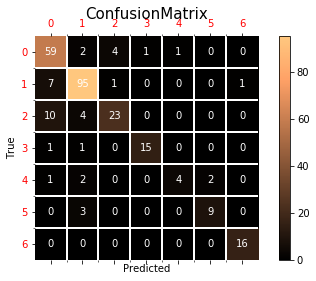

-------------------------------------------------------


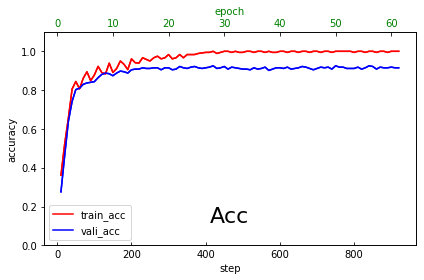

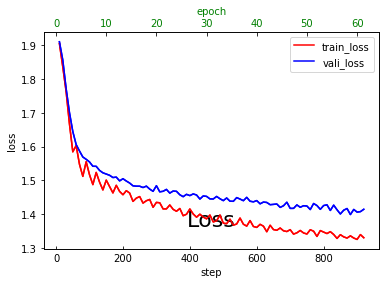

-------------------------------------------
Restoring Model Variables...
INFO:tensorflow:Restoring parameters from E:\spectralworkbench_crawler\nnSIC\OutputModel\201901032331\MyDataV2_m1
Time usage : 0:00:00.534030 
-------------------------------------------
neon_21411.png :
TrueLabel   = 3
PredLabel   = 1
Probability = ['0.07', '0.40', '0.10', '0.19', '0.08', '0.09', '0.07'] 

cfl_P_20180714_conti.jpg :
TrueLabel   = 1
PredLabel   = 1
Probability = ['0.13', '0.43', '0.12', '0.07', '0.05', '0.08', '0.11'] 

cfl_DSC5202.JPG :
TrueLabel   = 1
PredLabel   = 1
Probability = ['0.13', '0.51', '0.08', '0.06', '0.07', '0.07', '0.08'] 

neon_IMG_9999_full.JPG :
TrueLabel   = 3
PredLabel   = 1
Probability = ['0.05', '0.60', '0.04', '0.03', '0.10', '0.05', '0.13'] 

neon_DSC_2624.JPG :
TrueLabel   = 3
PredLabel   = 5
Probability = ['0.05', '0.06', '0.04', '0.07', '0.15', '0.61', '0.03'] 

cfl_2936.png :
TrueLabel   = 1
PredLabel   = 1
Probability = ['0.09', '0.60', '0.05', '0.06', '0.07', '0.06'

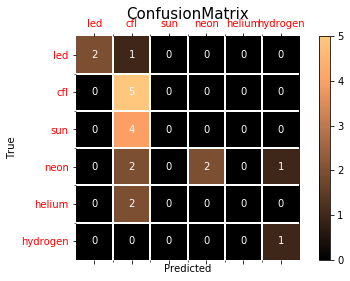

MyRealImgs Acc: 50.00%
-------------------------------------------


In [10]:
if __name__ == '__main__':
    # Setting static parameter    
    input_main_path = os.path.join(os.getcwd(),'InputData')  
    inputdata_path = {'train':os.path.join(input_main_path,'MyDataV2_train.tfrecords'),
                      'vali':os.path.join(input_main_path,'MyDataV2_vali.tfrecords'),
                      'test':os.path.join(input_main_path,'MyDataV2_test.tfrecords')}    
    save_main_path = os.path.join(os.getcwd(),'OutputModel',datetime.now().strftime("%Y%m%d%H%M"))             
    model_savepath = os.path.join(save_main_path,'MyDataV2_m1')
    model_earlystop_savepath = os.path.join(save_main_path,'MyDataV2_m1_earlystop')    
    if not os.path.exists(save_main_path): os.makedirs(save_main_path)       
    data_size = {'train':2639,'vali':294,'test':262}
    label_size = 7
    image_shape = [15,480]
        
    # Setting hyper parameter 
    batch_size = {'train':180,'vali':294,'test':262}
    learn_rate = 0.0002#0.0001 
    fc_layer_neuro_size = 256 #  
    convolution_kernel_size = 21 #
    dropout = 0.5
    
    # Setting iter. number and training       
    iter_number = 1000
    epoch = round(iter_number*(batch_size['train']/data_size['train']))
    tf.reset_default_graph()
    result = RunTraining(iter_number,evalValiConfusion=True)
    PlotAccLoss(result,save=True)
    SaveAccLossValue(result)
    
    ###########################################################
    """
    # Restore model_earlystop variable 
    tf.reset_default_graph()
    sess = tf.Session()
    modelpath = model_earlystop_savepath
    x_img, y_label, keep_prob, training, output_propb, output_label = RestoreModelVariable(sess,modelpath)

    acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output_propb, 1), tf.argmax(y_label, 1)), tf.float32))
    confusion = tf.confusion_matrix(labels=tf.argmax(y_label, 1), predictions=tf.argmax(output_propb, 1), num_classes=7)

    from ReadTFRecords import InputData
    data = InputData(sess, inputdata_path['test'], batch_size['test'], image_shape, label_size)                                                                                    
    image_batch, label_batch = data.feeder(data.the_iterator)                
    accuracy, confusion_mtx = sess.run([acc, confusion],
                                       feed_dict={x_img: image_batch*(1./255), 
                                                  y_label: label_batch,
                                                  keep_prob: 1.0})              
    print ('Acc: %4.2f%%'%(accuracy*100))  
    print ('ConfusionMatrix: \n',confusion_mtx)    
    PlotConfusionMatrix(confusion_mtx, show=True, save=False)
    sess.close()
    """
    ###########################################################
    #modelpath = os.path.join(os.getcwd(),'OutputModel','201812301003','MyDataV1_m1')
                                                                             
    modelpath = model_savepath
    PredMyRealImgs(modelpath)